# Variational Autoencoders

In [ ]:
%cd "../"

In [2]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [3]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]
    

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.01)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu3 = nn.LeakyReLU(0.01)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        x = self.flatten(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Linear(in_features=2, out_features=3136)
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.relu1 = nn.LeakyReLU(0.01)
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, stride=2, kernel_size=3, padding=1)
        self.relu2 = nn.LeakyReLU(0.01)
        self.trans_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=0)                
        self.relu3 = nn.LeakyReLU(0.01)
        self.trans_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, stride=1, kernel_size=3, padding=0)        
        self.trim = Trim()

        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 64, 7, 7)
        x = self.relu1(self.trans_conv1(x))
        x = self.relu2(self.trans_conv2(x))
        x = self.relu3(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = self.trim(x)
        return x

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)        
        self.out = nn.Sigmoid()

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).cuda()
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        decoded = self.out(decoded)
        return encoded, z_mean, z_log_var, decoded

In [4]:
x = torch.randn(1, 1, 28, 28).cuda()
model = VAE().cuda()
encoded, z_mean, z_log_var, decoded = model(x)

In [5]:
image = Image.open("samples/cock.jpg").resize((28, 28))
image = np.array(image)[:,:,0]
x = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(torch.float32).cuda()
_, _, _, decoded = model(x)

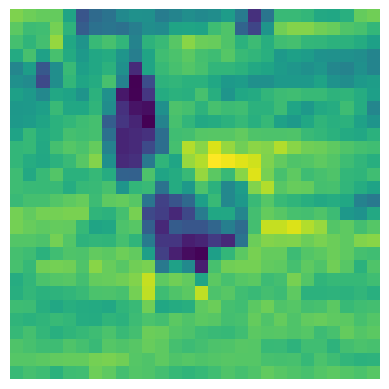

In [8]:
plt.axis("off")
plt.imshow(image)
plt.show()